In [11]:
!pip install ultralytics
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import cv2
import json
import shutil
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from ultralytics import YOLO
from tqdm import tqdm
import time

# Set random seed for reproducibility
random.seed(42)

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle/input')
print(f"Running on Kaggle: {is_kaggle}")

# Set paths based on environment
if is_kaggle:
    # Kaggle paths
    root_dir = '/kaggle/input/chessred'
    annotations_file = os.path.join(root_dir, 'annotations.json')
    image_dir = os.path.join(root_dir, 'chessred2k')
else:
    # Local paths
    root_dir = '.'
    annotations_file = os.path.join('chessred2k', 'annotations.json')
    image_dir = 'chessred2k'

# Check if required files and directories exist
if os.path.exists(image_dir):
    print(f"Found images directory: {image_dir}")
else:
    print(f"Images directory not found at {image_dir}")

if os.path.exists(annotations_file):
    print(f"Found annotations file: {annotations_file}")
else:
    print(f"Annotations file not found at {annotations_file}")

Using cuda device
Running on Kaggle: True
Found images directory: /kaggle/input/chessred/chessred2k
Found annotations file: /kaggle/input/chessred/annotations.json


In [12]:
def chesspos2number(chesspos):
    """Convert chess position (e.g., 'a1') to zero-indexed row and column"""
    col = ord(chesspos[0]) - ord('a')
    row = int(chesspos[1]) - 1
    return row, col

class ChessDatasetWithBBoxes(Dataset):
    """Chess dataset that uses the actual bounding boxes from annotations"""
    
    def __init__(self, image_dir, annotations_file, partition='train', transform=None):
        """
        Initialize the dataset with actual bounding box annotations.
        
        Args:
            image_dir: Directory containing the dataset images
            annotations_file: Path to annotations.json file
            partition: 'train', 'valid' or 'test'
            transform: Optional transforms to apply to images
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Load annotations
        print(f"Loading annotations from {annotations_file}")
        self.anns = json.load(open(annotations_file))
        self.categories = [c['name'] for c in self.anns['categories']]
        
        # Map category IDs to names for easier reference
        self.category_map = {}
        for cat in self.anns['categories']:
            self.category_map[cat['id']] = cat['name']
        
        # Load image information
        self.ids = []
        self.file_names = []
        for img in self.anns['images']:
            self.file_names.append(img['path'])
            self.ids.append(img['id'])
        
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Initialize board state
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        
        # Create a mapping from image ID to annotations and corners
        self.img_to_annots = {img_id: [] for img_id in self.ids}
        self.img_to_corners = {img_id: None for img_id in self.ids}
        
        # Process piece annotations with bounding boxes
        for piece in self.anns['annotations']['pieces']:
            img_id = piece['image_id']
            idx = np.where(self.ids == img_id)[0][0]
            
            # Record board position
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1
            
            # Store the annotation with the image
            if 'bbox' in piece:
                self.img_to_annots[img_id].append({
                    'bbox': piece['bbox'],
                    'category_id': piece['category_id'],
                    'position': piece['chessboard_position']
                })
        
        # Process corner annotations
        for corner in self.anns['annotations']['corners']:
            img_id = corner['image_id']
            self.img_to_corners[img_id] = corner['corners']
        
        # Get the split indices for the specified partition
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)
        
        # Filter data based on split
        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]
        
        # Count pieces for each image
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        
        print(f"Number of {partition} images: {len(self.file_names)}")
        
        # Print piece count statistics
        piece_counts = self.num_pieces.numpy().astype(int)
        print(f"Piece count statistics - min: {np.min(piece_counts)}, max: {np.max(piece_counts)}, mean: {np.mean(piece_counts):.2f}")
        
        # Verify we have annotations
        total_boxes = sum(len(self.img_to_annots[img_id]) for img_id in self.ids)
        print(f"Total bounding boxes in {partition} set: {total_boxes}")

        # Print a sample file path to help with debugging
        if len(self.file_names) > 0:
            print(f"Sample image path: {self.file_names[0]}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        try:
            # Get image path
            image_path = os.path.join(self.image_dir, self.file_names[i])
            
            # Load image
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                image = np.zeros((640, 640, 3), dtype=np.uint8)
            else:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    image = np.zeros((640, 640, 3), dtype=np.uint8)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Get annotations for this image
            img_id = self.ids[i]
            annotations = self.img_to_annots[img_id]
            corners = self.img_to_corners[img_id]
            
            # Count pieces from board state
            num_pieces = int(self.num_pieces[i].item())
            
            # Get original image dimensions for normalization
            original_h, original_w = image.shape[:2]
            
            # Apply transform to image if specified
            if self.transform:
                image = self.transform(image)
            
            return image, num_pieces, annotations, corners, (original_h, original_w), image_path
            
        except Exception as e:
            print(f"Error loading image {i}: {str(e)}")
            # Return placeholder if there's an error
            return np.zeros((640, 640, 3), dtype=np.uint8), 0, [], None, (0, 0), ""

In [13]:
# Create dataset instances using the global paths
train_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='train'
)

valid_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='valid'
)

test_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='test'
)

# Let's inspect the annotations for a single image
if len(train_dataset) > 0:
    sample_idx = 0
    img, count, annotations, corners, dims, img_path = train_dataset[sample_idx]

    print(f"\nSample image from training set:")
    print(f"Image path: {img_path}")
    print(f"Dimensions: {dims}")
    print(f"Piece count: {count}")
    print(f"Number of bounding boxes: {len(annotations)}")
    
    # Print corner information
    if corners:
        print(f"Corners information:")
        for corner_name, coords in corners.items():
            print(f"  {corner_name}: {coords}")
    else:
        print("No corner information found.")

    if annotations:
        print("\nExample annotations:")
        for i, ann in enumerate(annotations[:3]):  # Show first 3
            print(f"Annotation {i+1}:")
            print(f"  Position: {ann['position']}")
            print(f"  Category ID: {ann['category_id']}")
            print(f"  Bounding box: {ann['bbox']}")
    else:
        print("No annotations found for this image.")
else:
    print("No training images found.")

Loading annotations from /kaggle/input/chessred/annotations.json
Number of train images: 1442
Piece count statistics - min: 8, max: 32, mean: 21.31
Total bounding boxes in train set: 30723
Sample image path: images/19/G019_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of valid images: 330
Piece count statistics - min: 6, max: 32, mean: 18.58
Total bounding boxes in valid set: 6132
Sample image path: images/6/G006_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of test images: 306
Piece count statistics - min: 6, max: 32, mean: 20.57
Total bounding boxes in test set: 6294
Sample image path: images/0/G000_IMG000.jpg

Sample image from training set:
Image path: /kaggle/input/chessred/chessred2k/images/19/G019_IMG000.jpg
Dimensions: (3024, 3024)
Piece count: 32
Number of bounding boxes: 32
Corners information:
  bottom_right: [829.9, 868.11]
  bottom_left: [2272.28, 891.96]
  top_right: [471.59, 2213.29]
  top_left: [2


Visualizing samples with bounding boxes:


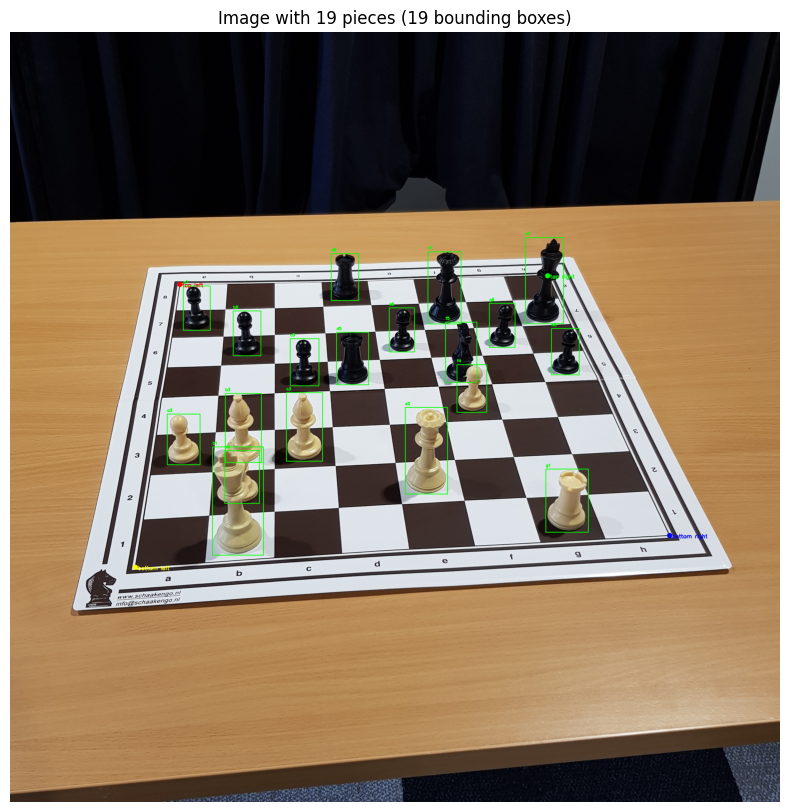

Image 1309 from /kaggle/input/chessred/chessred2k/images/91/G091_IMG070.jpg
Number of pieces: 19
Number of bounding boxes: 19
Chessboard corners:
  bottom_right: [2590.42, 1977.19]
  top_right: [2111.76, 957.33]
  bottom_left: [492.3, 2102.7]
  top_left: [667.37, 991.0]
First annotation: {'bbox': [1261.45, 870.91, 108.46, 184.93], 'category_id': 7, 'position': 'd8'}


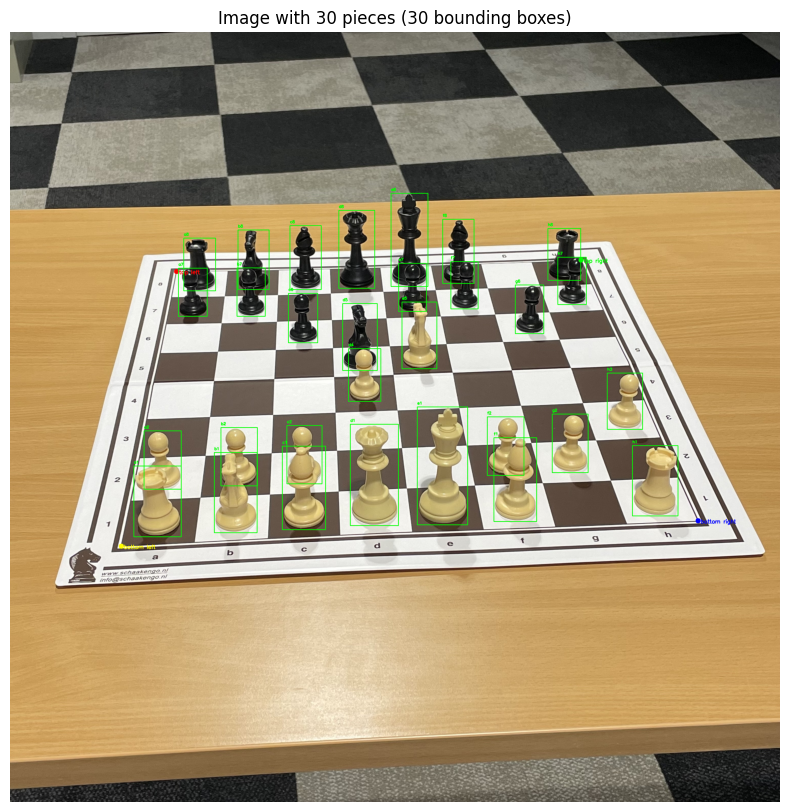

Image 228 from /kaggle/input/chessred/chessred2k/images/28/G028_IMG012.jpg
Number of pieces: 30
Number of bounding boxes: 30
Chessboard corners:
  bottom_left: [437.3, 2019.32]
  top_right: [2242.39, 895.62]
  bottom_right: [2702.31, 1919.17]
  top_left: [654.56, 940.59]
First annotation: {'bbox': [682.59, 809.82, 125.62, 207.03], 'category_id': 7, 'position': 'a8'}


In [14]:
def visualize_sample_with_bboxes(dataset, num_samples=3):
    """
    Visualize samples from the dataset with bounding boxes and chessboard corners
    """
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        img, count, annotations, corners, (h, w), img_path = dataset[idx]
        
        # Skip if it's a placeholder
        if h == 0 or w == 0:
            print(f"Skipping image {idx} (placeholder/error)")
            continue
            
        # Create a copy for drawing
        img_display = img.copy()
        
        # Draw chessboard corners if available
        if corners:
            # Define corner colors (BGR)
            corner_colors = {
                'top_left': (255, 0, 0),      # Red
                'top_right': (0, 255, 0),     # Green
                'bottom_right': (0, 0, 255),  # Blue
                'bottom_left': (255, 255, 0)  # Cyan
            }
            
            # Draw each corner as a circle with label
            for corner_name, coords in corners.items():
                x, y = int(coords[0]), int(coords[1])
                color = corner_colors.get(corner_name, (255, 255, 255))
                
                # Draw circle at corner position
                cv2.circle(img_display, (x, y), 10, color, -1)
                
                # Draw corner name
                cv2.putText(img_display, corner_name.replace('_', ' '), 
                           (x + 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # Draw bounding boxes on the image
        for i, ann in enumerate(annotations):
            bbox = ann['bbox']
            x, y, width, height = [int(v) for v in bbox]
            
            # Get category if available
            cat_id = ann.get('category_id', 0)
            cat_name = dataset.category_map.get(cat_id, f"Class {cat_id}")
            
            # Draw rectangle and label
            cv2.rectangle(img_display, (x, y), (x + width, y + height), (0, 255, 0), 2)
            cv2.putText(img_display, ann['position'], (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display the image
        plt.figure(figsize=(12, 10))
        plt.imshow(img_display)
        plt.title(f"Image with {count} pieces ({len(annotations)} bounding boxes)")
        plt.axis('off')
        plt.show()
        
        # Print annotations
        print(f"Image {idx} from {img_path}")
        print(f"Number of pieces: {count}")
        print(f"Number of bounding boxes: {len(annotations)}")
        
        # Print corner information
        if corners:
            print("Chessboard corners:")
            for corner_name, coords in corners.items():
                print(f"  {corner_name}: {coords}")

        if annotations:
            print("First annotation:", annotations[0])

# Visualize samples from the training set
print("\nVisualizing samples with bounding boxes:")
visualize_sample_with_bboxes(train_dataset, num_samples=2)

In [15]:
def prepare_yolo_dataset_with_corners(dataset_dict, output_dir='yolo_chess_dataset_with_corners'):
    """
    Prepare dataset in YOLO format with both piece and corner annotations in a single model
    
    Args:
        dataset_dict: Dictionary mapping split names to datasets
        output_dir: Directory to save the YOLO format dataset
    
    Returns:
        Path to the YOLO data.yaml file
    """
    print("Preparing YOLO dataset with both pieces and corners...")
    
    # Create necessary directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
    
    # Map our split names to YOLO's expected names
    split_mapping = {'train': 'train', 'valid': 'val', 'test': 'test'}
    
    # Get first dataset to extract category information
    first_dataset = next(iter(dataset_dict.values()))
    
    # Check all unique category IDs in the dataset
    all_category_ids = set()
    for _, dataset in dataset_dict.items():
        for i in range(len(dataset)):
            _, _, annotations, _, _, _ = dataset[i]
            for ann in annotations:
                if 'category_id' in ann:
                    all_category_ids.add(ann['category_id'])
    
    # Sort category IDs
    sorted_category_ids = sorted(list(all_category_ids))
    print(f"Found {len(sorted_category_ids)} unique piece category IDs: {sorted_category_ids}")
    
    # Create mapping from original category ID to sequential YOLO class ID (0-based)
    category_id_to_yolo_id = {cat_id: i for i, cat_id in enumerate(sorted_category_ids)}
    
    # Map category IDs to names for pieces
    category_names = []
    for cat_id in sorted_category_ids:
        if cat_id in first_dataset.category_map:
            category_names.append(first_dataset.category_map[cat_id])
        else:
            category_names.append(f"class_{cat_id}")
    
    # Add corner categories with their own class IDs
    corner_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_name_to_yolo_id = {name: len(category_names) + i for i, name in enumerate(corner_names)}
    
    # Add corner names to the category list
    category_names.extend(corner_names)
    
    print(f"Category mapping:")
    for cat_id, yolo_id in category_id_to_yolo_id.items():
        name = first_dataset.category_map.get(cat_id, f"class_{cat_id}")
        print(f"  Piece ID: {cat_id} -> YOLO ID: {yolo_id} ({name})")
    
    for corner_name, yolo_id in corner_name_to_yolo_id.items():
        print(f"  Corner: {corner_name} -> YOLO ID: {yolo_id}")
    
    # Process each split
    for split_name, dataset in dataset_dict.items():
        yolo_split = split_mapping.get(split_name, split_name)
        print(f"Processing {split_name} split with {len(dataset)} images...")
        
        # Process each image in the split
        for i in tqdm(range(len(dataset))):
            img, count, annotations, corners, (h, w), img_path = dataset[i]
            
            # Skip images without annotations, dimensions or corners
            if h == 0 or w == 0 or not annotations or not corners:
                continue
                
            # Save image with a unique filename
            img_filename = f"{split_name}_{i:06d}.jpg"
            img_output_path = os.path.join(output_dir, 'images', yolo_split, img_filename)
            
            if isinstance(img, np.ndarray):
                cv2.imwrite(img_output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
            # Create YOLO format labels
            label_path = os.path.join(output_dir, 'labels', yolo_split, f"{split_name}_{i:06d}.txt")
            with open(label_path, 'w') as f:
                # First write the piece annotations
                for ann in annotations:
                    # Get bounding box
                    bbox = ann['bbox']
                    x, y, width, height = bbox
                    
                    # Convert to YOLO format: class_id, x_center, y_center, width, height (normalized)
                    original_category_id = ann['category_id']
                    yolo_class_id = category_id_to_yolo_id.get(original_category_id, 0)  # Default to 0 if not found
                    
                    x_center = (x + width/2) / w
                    y_center = (y + height/2) / h
                    width_norm = width / w
                    height_norm = height / h
                    
                    # Write to file
                    f.write(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
                
                # Then write corner annotations
                # For corners, create small bounding boxes around each point
                corner_size = 0.02  # Size of corner box (2% of image width/height)
                for corner_name, coords in corners.items():
                    x, y = coords
                    
                    # Normalize coordinates
                    x_norm = x / w
                    y_norm = y / h
                    
                    # Get YOLO class ID for this corner
                    yolo_class_id = corner_name_to_yolo_id[corner_name]
                    
                    # Write to file
                    f.write(f"{yolo_class_id} {x_norm:.6f} {y_norm:.6f} {corner_size:.6f} {corner_size:.6f}\n")
    
    # Create YAML configuration file
    data_yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(data_yaml_path, 'w') as f:
        f.write(f"train: {os.path.join('images', 'train')}\n")
        f.write(f"val: {os.path.join('images', 'val')}\n")
        f.write(f"test: {os.path.join('images', 'test')}\n")
        
        # Write number of classes and names
        f.write(f"nc: {len(category_names)}\n")
        
        # Write class names in proper format
        category_str = "["
        for i, name in enumerate(category_names):
            if i > 0:
                category_str += ", "
            category_str += f"'{name}'"
        category_str += "]"
        f.write(f"names: {category_str}\n")
    
    print(f"YOLO dataset prepared at {output_dir}")
    print(f"Configuration file: {data_yaml_path}")
    print(f"Using {len(category_names)} categories ({len(sorted_category_ids)} pieces + 4 corners)")
    
    return data_yaml_path

# Prepare the combined dataset
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
}
data_yaml = prepare_yolo_dataset_with_corners(datasets)

Preparing YOLO dataset with both pieces and corners...
Found 12 unique piece category IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Category mapping:
  Piece ID: 0 -> YOLO ID: 0 (white-pawn)
  Piece ID: 1 -> YOLO ID: 1 (white-rook)
  Piece ID: 2 -> YOLO ID: 2 (white-knight)
  Piece ID: 3 -> YOLO ID: 3 (white-bishop)
  Piece ID: 4 -> YOLO ID: 4 (white-queen)
  Piece ID: 5 -> YOLO ID: 5 (white-king)
  Piece ID: 6 -> YOLO ID: 6 (black-pawn)
  Piece ID: 7 -> YOLO ID: 7 (black-rook)
  Piece ID: 8 -> YOLO ID: 8 (black-knight)
  Piece ID: 9 -> YOLO ID: 9 (black-bishop)
  Piece ID: 10 -> YOLO ID: 10 (black-queen)
  Piece ID: 11 -> YOLO ID: 11 (black-king)
  Corner: top_left -> YOLO ID: 12
  Corner: top_right -> YOLO ID: 13
  Corner: bottom_right -> YOLO ID: 14
  Corner: bottom_left -> YOLO ID: 15
Processing train split with 1442 images...


100%|██████████| 1442/1442 [02:36<00:00,  9.23it/s]


Processing valid split with 330 images...


100%|██████████| 330/330 [00:36<00:00,  9.16it/s]


Processing test split with 306 images...


100%|██████████| 306/306 [00:33<00:00,  9.20it/s]

YOLO dataset prepared at yolo_chess_dataset_with_corners
Configuration file: yolo_chess_dataset_with_corners/data.yaml
Using 16 categories (12 pieces + 4 corners)


In [16]:
def train_yolo_model(data_yaml, model_size='m', epochs=20):
    """
    Train YOLO11 model using the prepared dataset with real bounding boxes
    
    Args:
        data_yaml: Path to data.yaml file
        model_size: YOLO model size ('n', 's', 'm', 'l', 'x')
        epochs: Number of epochs to train
        
    Returns:
        Path to the best model weights
    """
    print(f"Training YOLO11-{model_size} model on dataset with real bounding boxes...")
    print(f"Training will run for {epochs} epochs")
    
    # Initialize model
    model = YOLO(f'yolo11{model_size}.pt')  # Load pretrained model
    
    # Set training parameters
    training_args = {
        'data': data_yaml,          # Path to dataset config
        'epochs': epochs,           # Number of epochs
        'imgsz': 640,               # Image size
        'batch': 16,                # Batch size
        'patience': 0,              # Early stopping patience
        'name': f'chess_detector_real_bbox_{model_size}',  # Run name
        'project': 'runs/detect',   # Project directory
        'device': 0 if device == 'cuda' else 'cpu',  # Device to use
        'verbose': True,            # Verbose output
        'exist_ok': True            # Overwrite existing output
    }
    
    # Train the model
    try:
        results = model.train(**training_args)
        
        # Get the best model path
        best_model_path = f'runs/detect/chess_detector_real_bbox_{model_size}/weights/best.pt'
        if os.path.exists(best_model_path):
            print(f"Training completed successfully.")
            print(f"Best model saved to: {best_model_path}")
            return best_model_path
        else:
            print(f"Training completed, but best model not found at expected path.")
            return None
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None

# Train the model
model_path = train_yolo_model(data_yaml, model_size='m', epochs=100)

Training YOLO11-m model on dataset with real bounding boxes...
Training will run for 100 epochs
Ultralytics 8.3.141 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_chess_dataset_with_corners/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_detector_real_bbox_m, nbs=64,

train: Scanning /kaggle/working/yolo_chess_dataset_with_corners/labels/train.cache... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 419.7±200.8 MB/s, size: 1870.3 KB)


val: Scanning /kaggle/working/yolo_chess_dataset_with_corners/labels/val.cache... 330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 330/330 [00:00<?, ?it/s]


Plotting labels to runs/detect/chess_detector_real_bbox_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/chess_detector_real_bbox_m
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.74G     0.6905      1.523     0.8664        107        640: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


                   all        330       7452       0.81      0.866      0.849      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.34G     0.5036     0.4519     0.8082         93        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        330       7452       0.88      0.931      0.928       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.36G     0.4711     0.3858      0.801         75        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        330       7452      0.954      0.948      0.969      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       8.6G      0.442      0.348     0.7975         62        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       7452      0.968      0.952      0.968      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       8.3G     0.4297     0.3297     0.7965        112        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        330       7452      0.968      0.957      0.974      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.52G     0.4175     0.3229     0.7955         86        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


                   all        330       7452      0.967      0.954      0.971      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.81G     0.4082     0.3131     0.7922         84        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.83it/s]

                   all        330       7452      0.968      0.961      0.977      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.37G     0.4035     0.3089     0.7915         38        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       7452      0.956      0.952      0.972      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.39G     0.4033     0.3009     0.7917         50        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        330       7452      0.974      0.966      0.977      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.46G     0.3913     0.2892     0.7906        140        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.972      0.963      0.975      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.76G     0.3831     0.2815     0.7892         78        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        330       7452      0.974      0.965      0.976      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.48G     0.3759     0.2778     0.7892         29        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.971      0.959      0.978      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.39G     0.3767     0.2766     0.7879        170        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        330       7452       0.98      0.966      0.979      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.43G     0.3707     0.2716      0.788         77        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        330       7452      0.973      0.971       0.98      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.76G     0.3759     0.2686     0.7883         35        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        330       7452      0.981      0.967      0.979      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.39G     0.3653     0.2656     0.7869         94        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        330       7452       0.98       0.97      0.982      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       8.4G     0.3621     0.2618     0.7853         70        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        330       7452      0.984      0.971      0.981      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.29G     0.3571     0.2574     0.7856        115        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        330       7452      0.983      0.967      0.979      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.39G     0.3688     0.2616     0.7867         70        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.979       0.97      0.981      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.61G     0.3656     0.2567     0.7868         74        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        330       7452      0.977      0.965      0.982      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.49G     0.3522      0.247     0.7838        168        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        330       7452      0.981      0.976      0.983      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.43G     0.3536     0.2504     0.7851         44        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       7452      0.976       0.97      0.982      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.73G     0.3454     0.2442     0.7846         75        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.985      0.974       0.98      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.42G      0.338     0.2373     0.7823        128        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        330       7452       0.98      0.971      0.981      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.67G     0.3276     0.2338     0.7824         28        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       7452       0.98      0.976      0.982      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.55G     0.3427      0.239     0.7835         78        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        330       7452      0.977      0.975      0.983       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.74G     0.3358     0.2365     0.7839         50        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       7452      0.982      0.973      0.983      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.34G     0.3299     0.2359     0.7825         90        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.971      0.965       0.98      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.36G     0.3201     0.2297     0.7825         89        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


                   all        330       7452      0.981       0.97       0.98      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.57G     0.3149     0.2283     0.7818         56        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        330       7452      0.978      0.974      0.985      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.84G     0.3147     0.2292     0.7814         48        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.983      0.973      0.984      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.42G     0.3188     0.2272     0.7811         91        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.975      0.977      0.984      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.38G     0.3183     0.2258     0.7827         25        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.984      0.969      0.982      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.41G     0.3122     0.2219     0.7816         45        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        330       7452      0.981      0.977      0.986        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.77G      0.309     0.2219     0.7802         62        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       7452      0.975      0.977      0.982      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.38G     0.3097     0.2215     0.7809        109        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.982      0.976      0.984      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       8.4G     0.3019     0.2155     0.7808        134        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.983      0.973      0.983      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.32G      0.311     0.2189     0.7816         37        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        330       7452      0.983      0.977      0.984      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.71G     0.3035     0.2135     0.7819         33        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]

                   all        330       7452      0.982      0.977      0.985       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.47G     0.3009     0.2112     0.7791         86        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       7452       0.98      0.973      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.53G     0.3005     0.2112       0.78        168        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


                   all        330       7452      0.978      0.974      0.982      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.36G     0.2947     0.2081     0.7794         99        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452       0.98      0.971      0.983      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.31G      0.292     0.2083     0.7798         53        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        330       7452      0.987      0.975      0.986      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       8.4G     0.2905     0.2048     0.7787         62        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.984      0.979      0.985      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.5G     0.2893     0.2051     0.7779        119        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.988      0.975      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.43G     0.2923     0.2049     0.7784         61        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


                   all        330       7452      0.983      0.981      0.985       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.65G     0.2842     0.2006     0.7788         84        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        330       7452      0.988      0.979      0.986      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.45G     0.2942     0.2082     0.7797         51        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        330       7452      0.979      0.976      0.984      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.55G     0.2856     0.2021     0.7796         33        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.983      0.981      0.985      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.41G     0.2867      0.201     0.7787         21        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.985      0.983      0.986      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.82G     0.2844     0.2016     0.7796         77        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

                   all        330       7452      0.984       0.98      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       8.4G     0.2856     0.1999     0.7781         60        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        330       7452       0.98      0.978      0.986      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.43G     0.2815     0.1971     0.7766        201        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

                   all        330       7452      0.982       0.98      0.985      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.47G     0.2821     0.1967     0.7776         27        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        330       7452      0.984      0.975      0.986      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       8.7G     0.2793     0.1938     0.7774         54        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


                   all        330       7452      0.984      0.979      0.987      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       8.3G     0.2837     0.1969     0.7781         87        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


                   all        330       7452      0.982       0.98      0.986      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.49G     0.2764     0.1935     0.7772         34        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


                   all        330       7452      0.984      0.979      0.987      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.54G     0.2781     0.1933     0.7786        122        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        330       7452      0.986      0.979      0.989      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.81G     0.2711     0.1884     0.7769        114        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.988      0.978      0.988      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.75G     0.2691     0.1861     0.7764         87        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.987      0.975      0.989       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       8.5G     0.2659     0.1857     0.7759        139        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.982      0.983      0.986       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.39G     0.2791     0.1948      0.778         77        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]

                   all        330       7452      0.986      0.981      0.987      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.76G     0.2685     0.1878     0.7772         66        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        330       7452      0.981       0.98      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.65G     0.2694     0.1862     0.7765         72        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


                   all        330       7452      0.987       0.98      0.988      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.42G     0.2639     0.1813     0.7766         80        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        330       7452      0.982      0.983      0.989      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.38G     0.2633     0.1828     0.7776         53        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.987      0.981      0.988      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.78G     0.2625     0.1816      0.777         65        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


                   all        330       7452      0.982      0.983      0.988       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.44G     0.2649     0.1814     0.7766         95        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        330       7452      0.984      0.983      0.989      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.31G     0.2594     0.1779     0.7774         27        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.984      0.982      0.989      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.51G      0.265     0.1804      0.777         12        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.984      0.986      0.988      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.71G     0.2612     0.1782     0.7768         50        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        330       7452      0.987      0.982      0.988       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       8.4G     0.2563     0.1771     0.7748         46        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

                   all        330       7452      0.986      0.981      0.988      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       8.4G     0.2551     0.1766     0.7753         37        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        330       7452      0.987      0.982      0.988      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.51G     0.2545     0.1755     0.7756        113        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

                   all        330       7452      0.986       0.98      0.988      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.67G     0.2575     0.1771     0.7748         26        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.989      0.983      0.988      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.44G     0.2512     0.1725      0.774         34        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        330       7452       0.98      0.982      0.987       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.26G     0.2499     0.1704     0.7745         55        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        330       7452      0.989      0.985      0.989      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.33G     0.2501     0.1713     0.7755         59        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.986      0.979      0.989      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       8.7G     0.2503     0.1712     0.7754         96        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.983      0.983      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.38G     0.2474     0.1687     0.7742        113        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.985      0.982      0.989      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.36G     0.2499     0.1704     0.7768         34        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.988      0.983      0.988      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       8.3G     0.2475     0.1685     0.7749         50        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        330       7452       0.99      0.981      0.989       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.77G     0.2436     0.1667     0.7738         80        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.981      0.985      0.989      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.45G     0.2486     0.1688     0.7754        124        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


                   all        330       7452      0.985      0.984      0.989       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.43G     0.2424     0.1651     0.7744        160        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        330       7452      0.984      0.985      0.987      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.62G     0.2465     0.1679     0.7741         38        640: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        330       7452      0.983      0.983      0.988      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.77G      0.242     0.1644     0.7737         90        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        330       7452      0.987      0.982      0.989      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.48G     0.2409     0.1633     0.7737         53        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


                   all        330       7452      0.984      0.984       0.99      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       8.4G     0.2383     0.1625     0.7737         43        640: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        330       7452      0.985      0.982       0.99      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.46G     0.2379     0.1602     0.7755         27        640: 100%|██████████| 91/91 [01:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

                   all        330       7452      0.984      0.984       0.99      0.823


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.56G     0.2184     0.1453     0.7644         55        640: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.83it/s]

                   all        330       7452      0.985      0.982      0.989      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.21G     0.2158     0.1436     0.7645         40        640: 100%|██████████| 91/91 [01:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

                   all        330       7452      0.985      0.978      0.987      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.18G     0.2111     0.1403     0.7638         40        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


                   all        330       7452      0.987      0.981      0.988      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.21G     0.2085     0.1392     0.7637         57        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        330       7452      0.986      0.978      0.988      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.56G     0.2074     0.1379     0.7638         46        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        330       7452      0.985      0.982      0.989      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.33G     0.2107     0.1394     0.7648         56        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


                   all        330       7452      0.984      0.979      0.988       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.18G     0.2046     0.1362     0.7627         33        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]

                   all        330       7452      0.982      0.982      0.989      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.33G     0.2018     0.1342     0.7637         40        640: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        330       7452      0.982      0.986      0.989      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.56G     0.2032     0.1345     0.7631         52        640: 100%|██████████| 91/91 [01:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        330       7452      0.984      0.983      0.989      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.21G     0.2019     0.1342     0.7622         72        640: 100%|██████████| 91/91 [01:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        330       7452      0.988       0.98       0.99      0.832



100 epochs completed in 2.152 hours.
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/best.pt, 40.5MB

Validating runs/detect/chess_detector_real_bbox_m/weights/best.pt...
Ultralytics 8.3.141 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 125 layers, 20,042,368 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


                   all        330       7452      0.978      0.974      0.985      0.846
            white-pawn        330       1625      0.997          1      0.995      0.864
            white-rook        281        447      0.998          1      0.995      0.853
          white-knight        220        274      0.998          1      0.995      0.875
          white-bishop        235        335      0.999          1      0.995      0.888
           white-queen        126        126      0.987          1      0.993      0.933
            white-king        330        330      0.998      0.997      0.995      0.933
            black-pawn        330       1511      0.998      0.999      0.995      0.872
            black-rook        280        471      0.999          1      0.995      0.897
          black-knight        125        178      0.991          1      0.995      0.848
          black-bishop        223        380      0.988          1      0.995      0.886
           black-quee

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 12.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/chess_detector_real_bbox_m
Training completed successfully.
Best model saved to: runs/detect/chess_detector_real_bbox_m/weights/best.pt


Evaluating model from runs/detect/chess_detector_real_bbox_m/weights/best.pt on test data...
Corner class indices: [12, 13, 14, 15]


  0%|          | 0/306 [00:00<?, ?it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/306 [00:00<02:17,  2.21it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 2 top_lefts, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 3/306 [00:00<00:57,  5.25it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 1 white-bishop, 8 black-pawns, 2 black-rooks, 4 black-knights, 3 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 4/306 [00:00<00:48,  6.23it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 5/306 [00:00<00:43,  6.93it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 3 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 10 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 7/306 [00:01<00:35,  8.33it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 9/306 [00:01<00:32,  9.12it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 11/306 [00:01<00:30,  9.65it/s]


0: 640x640 8 white-pawns, 3 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 8 black-pawns, 2 black-rooks, 3 black-knights, 3 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 13/306 [00:01<00:29,  9.95it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 8 black-pawns, 2 black-rooks, 3 black-knights, 3 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 15/306 [00:01<00:29, 10.01it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 9 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 17/306 [00:02<00:29,  9.89it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 19/306 [00:02<00:28, 10.14it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 4 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 21/306 [00:02<00:28, 10.17it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 23/306 [00:02<00:27, 10.33it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 25/306 [00:02<00:26, 10.42it/s]


0: 640x640 8 white-pawns, 3 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.1ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 27/306 [00:02<00:26, 10.48it/s]


0: 640x640 7 white-pawns, 3 white-rooks, 1 white-knight, 1 white-bishop, 1 white-king, 7 black-pawns, 2 black-rooks, 3 black-knights, 1 black-bishop, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 29/306 [00:03<00:26, 10.26it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 31/306 [00:03<00:26, 10.35it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 33/306 [00:03<00:25, 10.56it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-queen, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-bishop, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 35/306 [00:03<00:25, 10.48it/s]


0: 640x640 4 white-pawns, 2 white-rooks, 1 white-knight, 7 black-pawns, 2 black-rooks, 3 black-knights, 1 black-bishop, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 37/306 [00:03<00:26, 10.33it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 39/306 [00:04<00:25, 10.42it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.2ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 41/306 [00:04<00:25, 10.46it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 43/306 [00:04<00:25, 10.37it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-queen, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 45/306 [00:04<00:25, 10.42it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 47/306 [00:04<00:24, 10.42it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.6ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 49/306 [00:05<00:24, 10.41it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Processed 50 images. Current MAE: 0.5200

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 51/306 [00:05<00:24, 10.53it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-king, 6 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 53/306 [00:05<00:24, 10.54it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 55/306 [00:05<00:24, 10.33it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 57/306 [00:05<00:24, 10.34it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-queen, 1 white-king, 5 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 5 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 59/306 [00:06<00:24, 10.26it/s]


0: 640x640 4 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.0ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 5 black-pawns, 2 black-rooks, 1 black-knight, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 61/306 [00:06<00:24, 10.14it/s]


0: 640x640 4 white-pawns, 2 white-rooks, 1 white-knight, 4 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.5ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 63/306 [00:06<00:24, 10.06it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 4.4ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 2 white-rooks, 1 white-king, 4 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 4.5ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 65/306 [00:06<00:24,  9.85it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 4 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 66/306 [00:06<00:24,  9.79it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 6 black-pawns, 2 black-rooks, 2 black-knights, 3 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 3.8ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 68/306 [00:06<00:24,  9.90it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 69/306 [00:07<00:23,  9.88it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-bishop, 1 white-queen, 5 black-pawns, 2 black-rooks, 3 black-knights, 1 black-bishop, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 70/306 [00:07<00:24,  9.74it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 71/306 [00:07<00:24,  9.66it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.0ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 73/306 [00:07<00:23,  9.73it/s]


0: 640x640 3 white-pawns, 2 white-rooks, 1 white-queen, 4 black-pawns, 2 black-rooks, 2 black-knights, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 75/306 [00:07<00:23,  9.74it/s]


0: 640x640 2 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 76/306 [00:07<00:23,  9.79it/s]


0: 640x640 1 white-pawn, 2 white-rooks, 1 white-knight, 1 white-king, 4 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 78/306 [00:07<00:22,  9.99it/s]


0: 640x640 1 white-pawn, 3 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 2 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 80/306 [00:08<00:22, 10.21it/s]


0: 640x640 1 white-pawn, 2 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.2ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 2 white-rooks, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 82/306 [00:08<00:21, 10.28it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.7ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 84/306 [00:08<00:21, 10.43it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 2 black-knights, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 86/306 [00:08<00:20, 10.51it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 88/306 [00:08<00:20, 10.72it/s]


0: 640x640 2 white-pawns, 2 white-rooks, 1 white-knight, 3 black-pawns, 1 black-rook, 2 black-knights, 3 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 3 black-pawns, 1 black-rook, 1 black-knight, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 90/306 [00:09<00:20, 10.71it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.2ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 92/306 [00:09<00:20, 10.62it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 94/306 [00:09<00:20, 10.56it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-knight, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 96/306 [00:09<00:20, 10.45it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-knight, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 98/306 [00:09<00:19, 10.59it/s]


0: 640x640 1 white-pawn, 1 white-rook, 3 black-pawns, 1 black-rook, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 100/306 [00:10<00:19, 10.55it/s]

Processed 100 images. Current MAE: 0.5000

0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 2 white-rooks, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 102/306 [00:10<00:19, 10.62it/s]


0: 640x640 1 white-pawn, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 104/306 [00:10<00:18, 10.71it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 9 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 106/306 [00:10<00:18, 11.01it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 4.5ms preprocess, 16.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 108/306 [00:10<00:17, 11.05it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 110/306 [00:10<00:17, 11.19it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 9 black-pawns, 2 black-rooks, 3 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 112/306 [00:11<00:17, 11.36it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 114/306 [00:11<00:16, 11.56it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 9 black-pawns, 2 black-rooks, 3 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 116/306 [00:11<00:16, 11.69it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 118/306 [00:11<00:15, 11.81it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 8 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 120/306 [00:11<00:15, 11.82it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 2 black-kings, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 122/306 [00:11<00:15, 11.90it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 124/306 [00:12<00:15, 11.90it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 126/306 [00:12<00:15, 11.88it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 8 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-queen, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 2 top_rights, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 128/306 [00:12<00:15, 11.85it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 130/306 [00:12<00:14, 11.80it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 132/306 [00:12<00:14, 11.92it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 8 black-pawns, 1 black-rook, 2 black-knights, 2 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 134/306 [00:12<00:14, 11.97it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 136/306 [00:13<00:14, 12.01it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 138/306 [00:13<00:14, 11.93it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 3 black-rooks, 1 black-knight, 3 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 140/306 [00:13<00:13, 12.09it/s]


0: 640x640 6 white-pawns, 2 white-rooks, 1 white-bishop, 1 white-queen, 6 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 2 white-rooks, 2 white-bishops, 1 white-queen, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 2 black-kings, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 142/306 [00:13<00:13, 12.23it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 2 top_rights, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 144/306 [00:13<00:13, 12.12it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 146/306 [00:13<00:13, 12.04it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 148/306 [00:14<00:13, 11.97it/s]


0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 4 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-knight, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 150/306 [00:14<00:13, 12.00it/s]

Processed 150 images. Current MAE: 0.5333

0: 640x640 5 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 152/306 [00:14<00:12, 11.96it/s]


0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 154/306 [00:14<00:12, 11.99it/s]


0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 5 black-pawns, 1 black-rook, 2 black-bishops, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 156/306 [00:14<00:12, 11.99it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 5 black-pawns, 1 black-rook, 2 black-bishops, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 158/306 [00:14<00:12, 12.06it/s]


0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-rook, 3 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 160/306 [00:15<00:12, 12.16it/s]


0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 5 black-pawns, 2 black-rooks, 3 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 6 black-pawns, 1 black-rook, 3 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 162/306 [00:15<00:11, 12.24it/s]


0: 640x640 4 white-pawns, 1 white-rook, 2 white-bishops, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 164/306 [00:15<00:11, 12.31it/s]


0: 640x640 4 white-pawns, 1 white-rook, 2 white-bishops, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 2 white-bishops, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 166/306 [00:15<00:11, 12.28it/s]


0: 640x640 4 white-pawns, 1 white-rook, 2 white-bishops, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 1 white-rook, 1 white-bishop, 6 black-pawns, 1 black-rook, 2 black-bishops, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 168/306 [00:15<00:11, 12.22it/s]


0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 5 black-pawns, 1 black-rook, 1 black-bishop, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 170/306 [00:15<00:11, 12.19it/s]


0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 1 white-bishop, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-bishop, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 172/306 [00:16<00:10, 12.21it/s]


0: 640x640 4 white-pawns, 1 white-king, 5 black-pawns, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 3.4ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 174/306 [00:16<00:10, 12.27it/s]


0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-bishop, 1 white-king, 4 black-pawns, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 176/306 [00:16<00:10, 12.28it/s]


0: 640x640 4 white-pawns, 1 white-bishop, 1 white-king, 4 black-pawns, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 5 black-pawns, 1 black-bishop, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 178/306 [00:16<00:10, 12.23it/s]


0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 180/306 [00:16<00:10, 12.34it/s]


0: 640x640 4 white-pawns, 4 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 5 black-pawns, 1 black-bishop, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 182/306 [00:16<00:09, 12.45it/s]


0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 184/306 [00:17<00:09, 12.45it/s]


0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 5 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 186/306 [00:17<00:09, 12.04it/s]


0: 640x640 4 white-pawns, 4 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 188/306 [00:17<00:09, 11.91it/s]


0: 640x640 4 white-pawns, 1 white-king, 5 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-king, 4 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 190/306 [00:17<00:10, 11.50it/s]


0: 640x640 4 white-pawns, 1 white-king, 5 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 4 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 4.2ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 192/306 [00:17<00:09, 11.59it/s]


0: 640x640 4 white-pawns, 3 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 white-pawns, 3 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 194/306 [00:17<00:09, 11.67it/s]


0: 640x640 3 white-pawns, 3 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 white-pawns, 1 white-king, 3 black-pawns, 1 black-king, 1 top_right, 2 bottom_rights, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 196/306 [00:18<00:09, 11.75it/s]


0: 640x640 2 white-pawns, 3 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 white-pawns, 1 white-king, 3 black-pawns, 1 black-king, 2 top_lefts, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 198/306 [00:18<00:09, 11.60it/s]


0: 640x640 2 white-pawns, 3 black-pawns, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-king, 4 black-pawns, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 200/306 [00:18<00:09, 11.62it/s]

Processed 200 images. Current MAE: 0.4650

0: 640x640 1 white-pawn, 3 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 3 black-pawns, 2 black-kings, 2 top_lefts, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.7ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 202/306 [00:18<00:08, 11.74it/s]


0: 640x640 1 white-pawn, 1 white-king, 3 black-pawns, 1 black-king, 2 top_lefts, 1 top_right, 1 bottom_left, 16.0ms
Speed: 3.8ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-pawn, 1 white-king, 3 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 204/306 [00:18<00:08, 11.66it/s]


0: 640x640 1 white-queen, 1 white-king, 3 black-pawns, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 white-king, 3 black-pawns, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 206/306 [00:18<00:08, 11.84it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 208/306 [00:19<00:08, 11.57it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 210/306 [00:19<00:08, 11.43it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 212/306 [00:19<00:08, 11.48it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 214/306 [00:19<00:08, 11.42it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 4.0ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 216/306 [00:19<00:08, 11.22it/s]


0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 218/306 [00:20<00:07, 11.16it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 220/306 [00:20<00:07, 11.09it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 2 black-queens, 1 black-king, 2 top_rights, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 222/306 [00:20<00:07, 11.23it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 3.5ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 224/306 [00:20<00:07, 11.27it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.6ms
Speed: 4.8ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 226/306 [00:20<00:07, 11.11it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 228/306 [00:20<00:07, 11.03it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 230/306 [00:21<00:06, 11.11it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 232/306 [00:21<00:06, 11.19it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 234/306 [00:21<00:06, 11.23it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.3ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 236/306 [00:21<00:06, 11.24it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 238/306 [00:21<00:06, 11.22it/s]


0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 240/306 [00:22<00:05, 11.13it/s]


0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 242/306 [00:22<00:05, 11.05it/s]


0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 244/306 [00:22<00:05, 11.05it/s]


0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 21.7ms
Speed: 5.1ms preprocess, 21.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 3 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 18.5ms
Speed: 7.9ms preprocess, 18.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 246/306 [00:22<00:06,  9.75it/s]


0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 20.0ms
Speed: 8.1ms preprocess, 20.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 19.5ms
Speed: 8.4ms preprocess, 19.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 248/306 [00:22<00:06,  8.74it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 4.3ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 250/306 [00:23<00:06,  9.17it/s]

Processed 250 images. Current MAE: 0.4120

0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 3.6ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 2 black-bishops, 2 black-queens, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 252/306 [00:23<00:05,  9.83it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-knight, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 254/306 [00:23<00:05, 10.35it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-bishop, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 256/306 [00:23<00:04, 10.73it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 6 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 258/306 [00:23<00:04, 10.94it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 260/306 [00:23<00:04, 11.15it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 5 black-pawns, 1 black-rook, 1 black-queen, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 262/306 [00:24<00:03, 11.05it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 264/306 [00:24<00:03, 11.17it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 266/306 [00:24<00:03, 11.28it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 268/306 [00:24<00:03, 11.42it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 270/306 [00:24<00:03, 11.46it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 5 black-pawns, 2 black-rooks, 2 black-queens, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 272/306 [00:25<00:02, 11.44it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 274/306 [00:25<00:02, 11.40it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 276/306 [00:25<00:02, 11.47it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 278/306 [00:25<00:02, 11.51it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.0ms
Speed: 3.4ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 280/306 [00:25<00:02, 11.45it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 282/306 [00:25<00:02, 11.40it/s]


0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 284/306 [00:26<00:01, 11.38it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 286/306 [00:26<00:01, 11.37it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.8ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 288/306 [00:26<00:01, 11.44it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-bishop, 1 top_left, 1 bottom_right, 2 bottom_lefts, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 290/306 [00:26<00:01, 11.44it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.2ms
Speed: 3.6ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 292/306 [00:26<00:01, 11.49it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 294/306 [00:26<00:01, 11.50it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 296/306 [00:27<00:00, 11.42it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 298/306 [00:27<00:00, 11.39it/s]


0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 300/306 [00:27<00:00, 11.33it/s]

Processed 300 images. Current MAE: 0.3567

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.7ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 302/306 [00:27<00:00, 11.34it/s]


0: 640x640 4 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 304/306 [00:27<00:00, 11.43it/s]


0: 640x640 4 white-pawns, 1 white-rook, 4 black-pawns, 1 black-rook, 2 black-kings, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 white-pawns, 1 white-rook, 1 white-king, 3 black-pawns, 1 black-rook, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 16.1ms
Speed: 3.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 306/306 [00:27<00:00, 10.93it/s]


Test Results:
Mean Absolute Error (MAE): 0.3497
Root Mean Square Error (RMSE): 0.7983
MAE for 6-10 pieces: 0.3469 (n=49)
MAE for 11-15 pieces: 0.2698 (n=63)
MAE for 16-20 pieces: 0.1346 (n=52)
MAE for 21-32 pieces: 0.4648 (n=142)


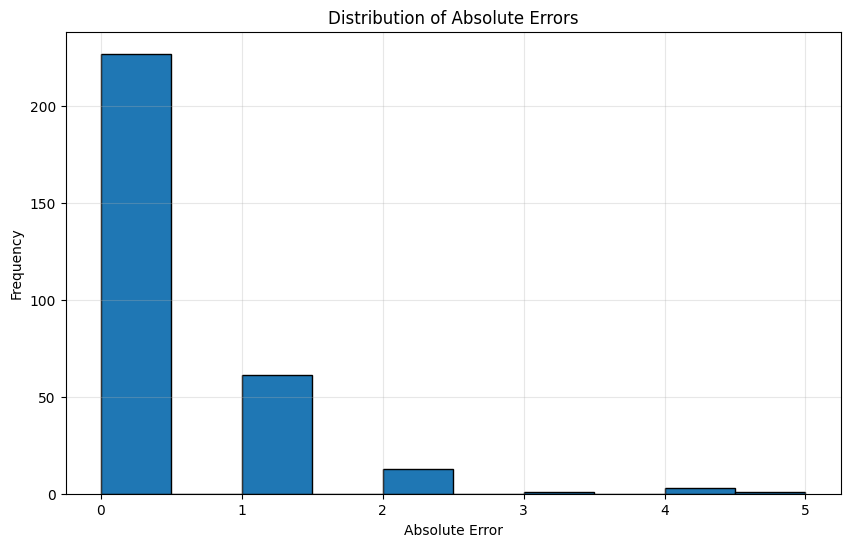

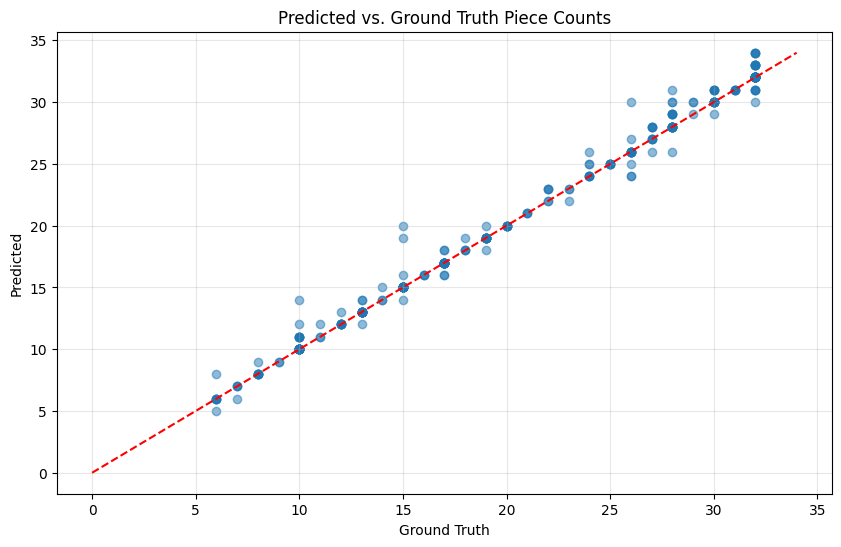

In [17]:
def evaluate_model(model_path, test_dataset):
    """
    Evaluate the trained YOLO model on the test dataset
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset with bounding box annotations
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    print(f"Evaluating model from {model_path} on test data...")
    
    # Load the model
    model = YOLO(model_path)
    
    # Get the class names from the model
    class_names = model.names
    
    # Find corner classes in the model's class names
    corner_class_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_indices = [idx for idx, name in class_names.items() if name in corner_class_names]
    
    print(f"Corner class indices: {corner_indices}")
    
    # Initialize metrics
    results = {
        'predictions': [],
        'ground_truth': [],
        'absolute_errors': [],
        'squared_errors': []
    }
    
    # Create test dataloader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Process each test image
    for i, (img, gt_count, annotations, corners, dims, img_path) in enumerate(tqdm(test_loader)):
        # Get image
        if isinstance(img, list):
            img = img[0]
        elif isinstance(img, torch.Tensor):
            img = img.numpy()[0]
            
        # Get ground truth count
        gt_count = int(gt_count.item())
        
        # Skip invalid images
        if img.size == 0 or dims[0].item() == 0:
            continue
            
        # Run inference
        detection_results = model(img, conf=0.50)  # Lower threshold to detect more pieces
        
        # Get all detections
        boxes = detection_results[0].boxes
        
        # Separate piece and corner detections - only count pieces
        piece_boxes = boxes[~np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        
        # Count pieces only (not corners)
        pred_count = len(piece_boxes)
        
        # Store results
        results['predictions'].append(pred_count)
        results['ground_truth'].append(gt_count)
        results['absolute_errors'].append(abs(pred_count - gt_count))
        results['squared_errors'].append((pred_count - gt_count) ** 2)
        
        # Print progress every 50 images
        if (i + 1) % 50 == 0:
            current_mae = np.mean(results['absolute_errors'])
            print(f"Processed {i+1} images. Current MAE: {current_mae:.4f}")
    
    # Calculate final metrics
    mae = np.mean(results['absolute_errors'])
    mse = np.mean(results['squared_errors'])
    rmse = np.sqrt(mse)
    
    print("\nTest Results:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    
    # Break down results by number of pieces
    ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 32)]
    for low, high in ranges:
        # Get indices of images with piece count in this range
        indices = [i for i, c in enumerate(results['ground_truth']) if low <= c <= high]
        
        if indices:
            range_abs_errors = [results['absolute_errors'][i] for i in indices]
            range_mae = np.mean(range_abs_errors)
            print(f"MAE for {low}-{high} pieces: {range_mae:.4f} (n={len(indices)})")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(results['absolute_errors'], bins=10, edgecolor='black')
    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.scatter(results['ground_truth'], results['predictions'], alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(results['ground_truth']), max(results['predictions']))
    plt.plot([0, max_val], [0, max_val], 'r--')
    
    plt.title('Predicted vs. Ground Truth Piece Counts')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Evaluate the model (replace with your trained model path if needed)
if model_path and os.path.exists(model_path):
    evaluation_results = evaluate_model(model_path, test_dataset)
else:
    print("No model available for evaluation. Please train the model first.")


Visualizing piece and corner predictions:

--- Image 158 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG055.jpg
Actual piece count: 18
Number of ground truth bounding boxes: 18

0: 640x640 5 white-pawns, 1 white-rook, 2 white-bishops, 1 white-king, 5 black-pawns, 1 black-rook, 2 black-bishops, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 17.6ms
Speed: 3.6ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 18
Error: 0
Detected 4 of 4 corners
Ground truth corners:
  bottom_right: [2344.36, 2081.54]
  top_left: [1055.89, 1005.84]
  bottom_left: [426.16, 1805.3]
  top_right: [2588.99, 1180.85]
Predicted corners:
  bottom_left: Position (426.1, 1803.7), Confidence: 0.88
  top_right: Position (2590.9, 1183.1), Confidence: 0.88
  bottom_right: Position (2345.7, 2083.0), Confidence: 0.84
  top_left: Position (1055.6, 1004.7), Confidence: 0.84


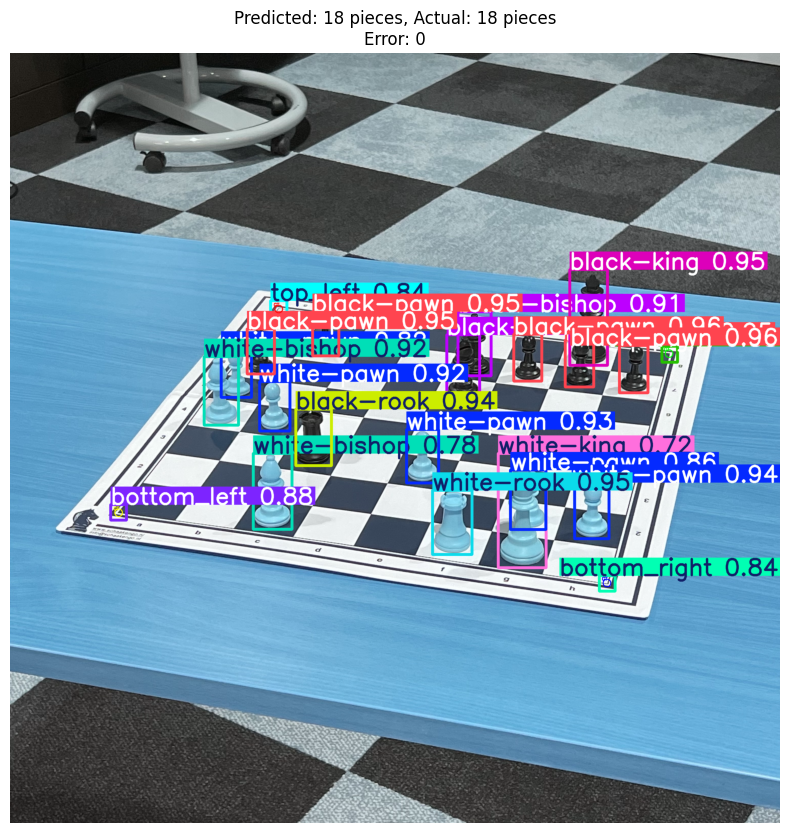


--- Image 50 ---
Path: /kaggle/input/chessred/chessred2k/images/0/G000_IMG050.jpg
Actual piece count: 19
Number of ground truth bounding boxes: 19

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 2 black-kings, 1 top_left, 1 bottom_right, 1 bottom_left, 17.7ms
Speed: 3.6ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 20
Error: 1
Detected 3 of 4 corners
Ground truth corners:
  bottom_left: [2520.56, 2354.9]
  bottom_right: [2541.74, 1082.06]
  top_left: [329.7, 2170.1]
  top_right: [875.34, 1017.56]
Predicted corners:
  bottom_left: Position (2514.5, 2354.1), Confidence: 0.88
  top_left: Position (331.9, 2171.4), Confidence: 0.88
  bottom_right: Position (2539.1, 1083.7), Confidence: 0.88


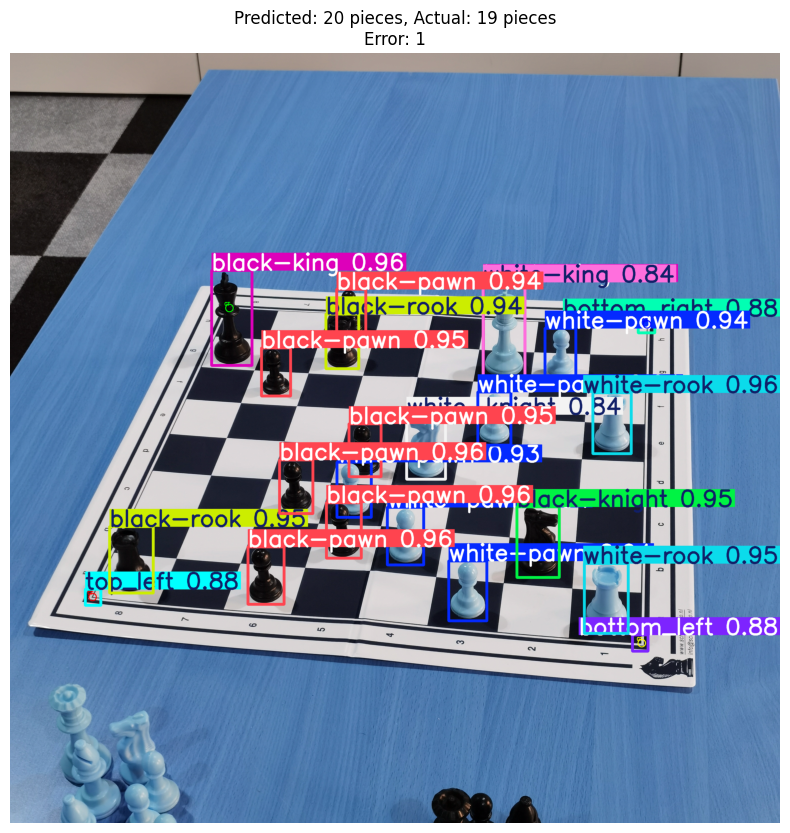


--- Image 37 ---
Path: /kaggle/input/chessred/chessred2k/images/0/G000_IMG037.jpg
Actual piece count: 25
Number of ground truth bounding boxes: 25

0: 640x640 6 white-pawns, 2 white-rooks, 2 white-knights, 1 white-bishop, 1 white-queen, 1 white-king, 7 black-pawns, 2 black-rooks, 2 black-knights, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 17.7ms
Speed: 3.8ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 25
Error: 0
Detected 4 of 4 corners
Ground truth corners:
  bottom_right: [386.4, 2299.24]
  bottom_left: [748.91, 1039.48]
  top_right: [2451.27, 2342.38]
  top_left: [2251.34, 1045.53]
Predicted corners:
  bottom_right: Position (386.5, 2296.3), Confidence: 0.88
  bottom_left: Position (753.2, 1043.2), Confidence: 0.87
  top_left: Position (2249.3, 1048.0), Confidence: 0.86
  top_right: Position (2446.6, 2344.6), Confidence: 0.81


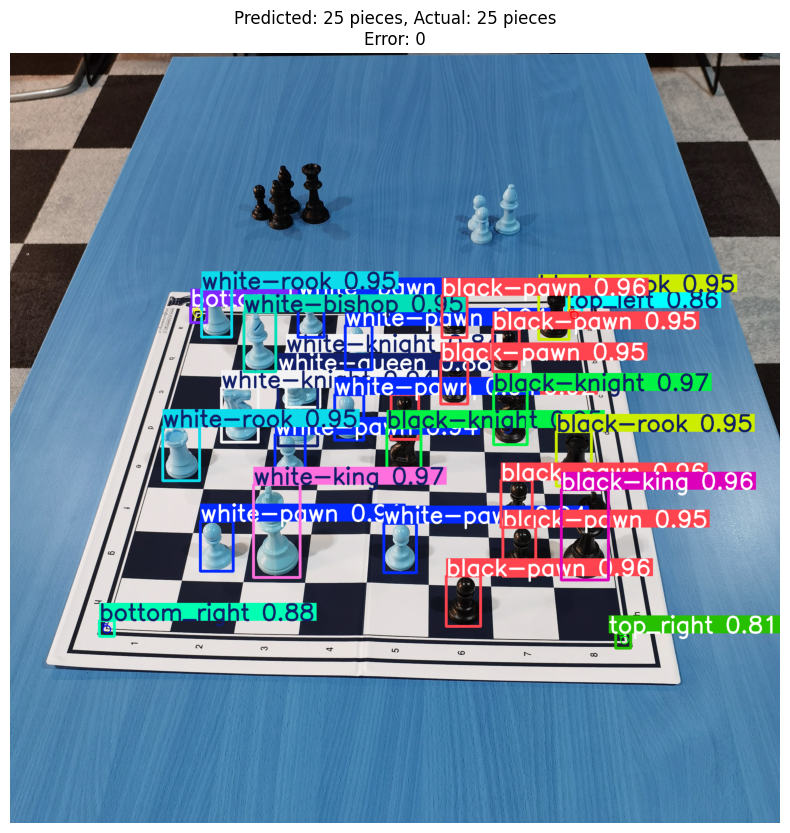


--- Image 169 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG066.jpg
Actual piece count: 15
Number of ground truth bounding boxes: 15

0: 640x640 4 white-pawns, 1 white-rook, 1 white-bishop, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 17.7ms
Speed: 3.5ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 15
Error: 0
Detected 4 of 4 corners
Ground truth corners:
  bottom_left: [683.7, 2284.1]
  top_left: [307.76, 1356.8]
  bottom_right: [2668.98, 1791.87]
  top_right: [1829.24, 1081.69]
Predicted corners:
  bottom_left: Position (680.9, 2285.0), Confidence: 0.89
  bottom_right: Position (2669.3, 1792.6), Confidence: 0.89
  top_left: Position (304.6, 1355.7), Confidence: 0.80
  top_right: Position (1819.4, 1083.0), Confidence: 0.61


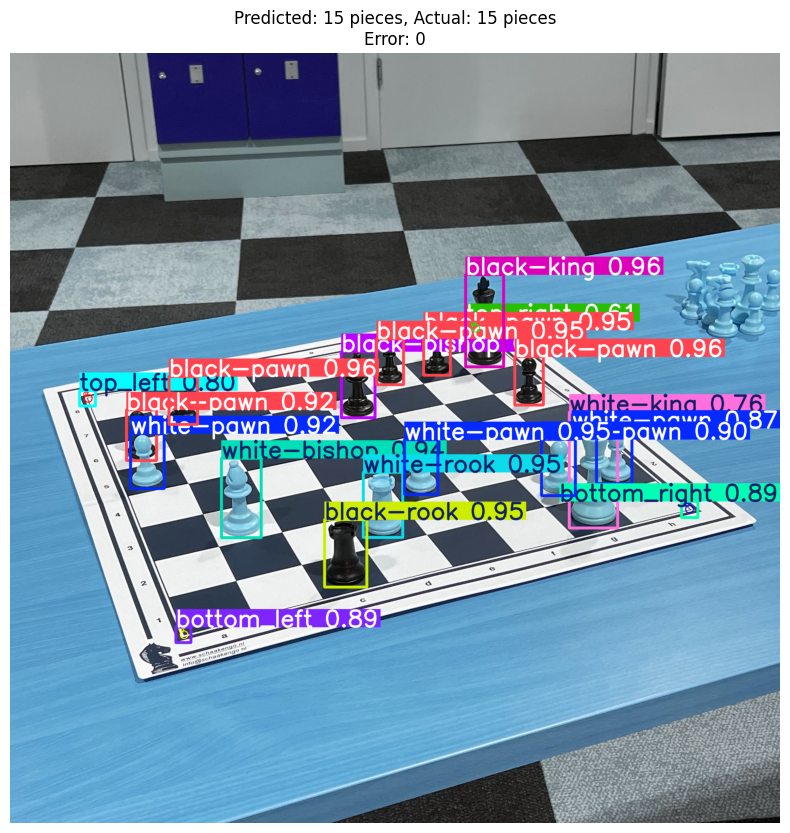


--- Image 241 ---
Path: /kaggle/input/chessred/chessred2k/images/76/G076_IMG035.jpg
Actual piece count: 26
Number of ground truth bounding boxes: 26

0: 640x640 7 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 7 black-pawns, 1 black-rook, 1 black-knight, 2 black-bishops, 1 black-queen, 1 black-king, 1 top_left, 1 top_right, 1 bottom_right, 1 bottom_left, 17.7ms
Speed: 3.5ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 26
Error: 0
Detected 4 of 4 corners
Ground truth corners:
  top_left: [1159.19, 775.56]
  bottom_right: [2299.84, 2315.76]
  bottom_left: [359.58, 1788.98]
  top_right: [2630.65, 1046.98]
Predicted corners:
  bottom_left: Position (356.5, 1791.3), Confidence: 0.91
  top_left: Position (1160.4, 776.0), Confidence: 0.89
  top_right: Position (2630.3, 1046.5), Confidence: 0.88
  bottom_right: Position (2300.9, 2316.7), Confidence: 0.83


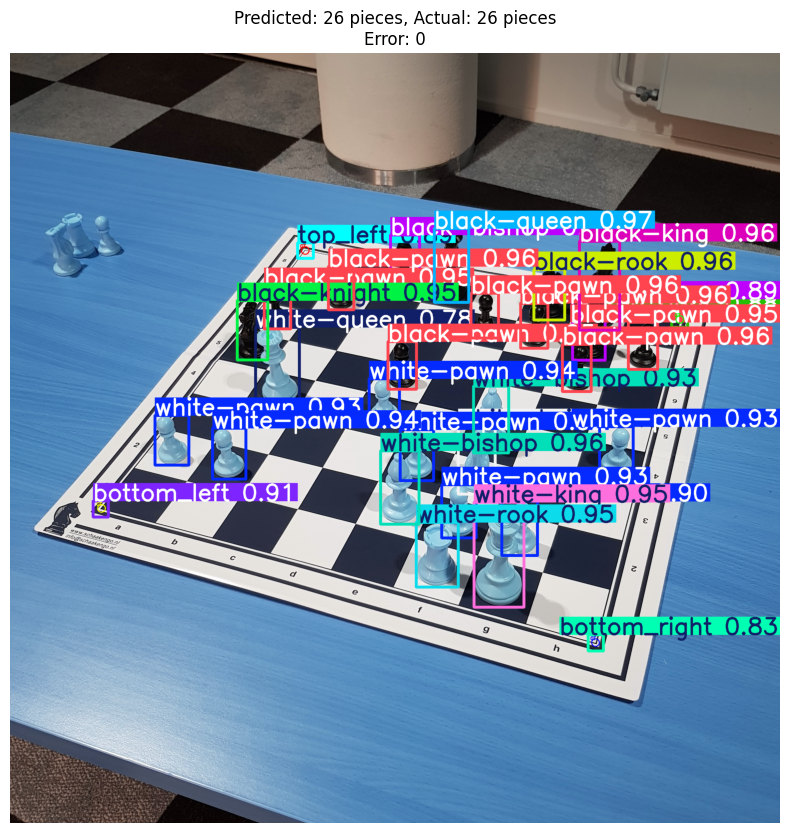

In [20]:
def visualize_piece_and_corner_predictions(model_path, test_dataset, num_samples=5):
    """
    Visualize model predictions for both chess pieces and board corners
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset
        num_samples: Number of samples to visualize
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    # Load the model
    model = YOLO(model_path)
    
    # Get the class names from the model
    class_names = model.names
    
    # Find corner classes in the model's class names
    corner_class_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_indices = [idx for idx, name in class_names.items() if name in corner_class_names]
    
    # Randomly sample images
    indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))
    
    for idx in indices:
        # Get sample
        img, gt_count, annotations, gt_corners, (h, w), img_path = test_dataset[idx]
        
        # Skip invalid images
        if h == 0 or w == 0:
            continue
            
        print(f"\n--- Image {idx} ---")
        print(f"Path: {img_path}")
        print(f"Actual piece count: {gt_count}")
        print(f"Number of ground truth bounding boxes: {len(annotations)}")
        
        # Run inference
        results = model(img, conf=0.50)  # Lower confidence for better visualization
        
        # Get all detections
        boxes = results[0].boxes
        
        # Separate piece and corner detections
        piece_boxes = boxes[~np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        corner_boxes = boxes[np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        
        # Count pieces
        pred_count = len(piece_boxes)
        
        print(f"Predicted piece count: {pred_count}")
        print(f"Error: {abs(pred_count - gt_count)}")
        print(f"Detected {len(corner_boxes)} of 4 corners")
        
        # Make a copy of the image for drawing
        img_display = img.copy() if isinstance(img, np.ndarray) else img
        
        # Plot all detections
        annotated_img = results[0].plot()
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        # Draw ground truth corners for comparison
        if gt_corners:
            # Define corner colors (RGB)
            corner_colors = {
                'top_left': (255, 0, 0),      # Red
                'top_right': (0, 255, 0),     # Green
                'bottom_right': (0, 0, 255),  # Blue
                'bottom_left': (255, 255, 0)  # Cyan
            }
            
            # Print ground truth corners
            print("Ground truth corners:")
            for corner_name, coords in gt_corners.items():
                print(f"  {corner_name}: {coords}")
                
                # Draw ground truth corner as dashed circle
                x, y = int(coords[0]), int(coords[1])
                color = corner_colors.get(corner_name, (255, 255, 255))
                cv2.circle(annotated_img_rgb, (x, y), 15, color, 2, lineType=cv2.LINE_AA)
                cv2.putText(annotated_img_rgb, f"GT", (x - 20, y - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Print predicted corners
        if len(corner_boxes) > 0:
            print("Predicted corners:")
            for box in corner_boxes:
                cls_id = int(box.cls.item())
                conf = box.conf.item()
                x, y, w, h = box.xywh.cpu().numpy()[0]
                corner_name = class_names[cls_id]
                print(f"  {corner_name}: Position ({x:.1f}, {y:.1f}), Confidence: {conf:.2f}")
        
        # Display
        plt.figure(figsize=(12, 10))
        plt.imshow(annotated_img_rgb)
        plt.title(f"Predicted: {pred_count} pieces, Actual: {gt_count} pieces\nError: {abs(pred_count - gt_count)}")
        plt.axis('off')
        plt.show()

# Visualize predictions from the combined model
if model_path and os.path.exists(model_path):
    print("\nVisualizing piece and corner predictions:")
    visualize_piece_and_corner_predictions(model_path, test_dataset, num_samples=5)
else:
    print("No model available for visualization. Please train the model first.")